In [1]:
import os
import rasterio
import json
import tarfile
import glob

import numpy as np
import pandas as pd
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt

## Getting to know the Sentinel data

setting up youre base path for predownloaded data (thank's to Tim :) )

In [2]:
base_path = '/Users/jebert/Documents/IRTG/workshops/NeuromatchAcademy/data'

## Sentinel-1
Skip this part if you are not interested in Sentinel-1 data

In [38]:
d_sent1 = {'filename_img_0': ['VV.tif'], 'filename_img_1': ['VH.tif'], 'filename_gt': ['labels.tif']}
df_sent1 = pd.DataFrame(data=d_sent1)

In [191]:
dataset_sent1 = rasterio.open(os.path.join(base_path, 'example_data_sent1', df_sent1['filename_img_0'][0]))
dataset_sent1_gt = rasterio.open(os.path.join(base_path, 'example_data_sent1', 'labels.tif'))
band_sent1 = dataset_sent1.read()
band_sent1_gt = dataset_sent1_gt.read()

Still weird stuff going on here....<br>
I will figure it out.

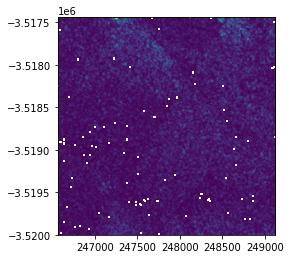

<AxesSubplot:>

In [192]:
show(dataset_sent1)

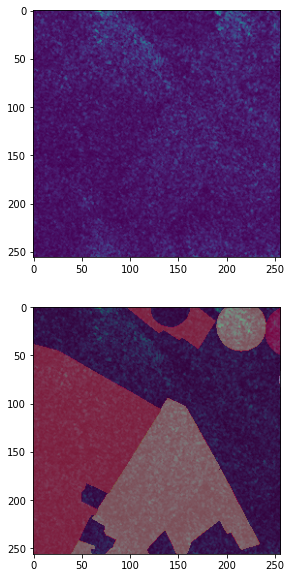

In [194]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.imshow(band_sent1[0, :, :])
ax2.imshow(band_sent1[0, :, :])
ax2.imshow(band_sent1_gt[0, :, :], alpha=0.3, cmap='hot')

## Sentinel-2

Reading in all files from the folders. <br> 
Day 1 - 4 - 11 

In [3]:
filelist_sent2_day1 = glob.glob(os.path.join(base_path, 'example_data_sent2', 'day1', "*"))
filelist_sent2_day4 = glob.glob(os.path.join(base_path, 'example_data_sent2', 'day4', "*"))
filelist_sent2_day14 = glob.glob(os.path.join(base_path, 'example_data_sent2', 'day14', "*"))


Removing the files we do not want, quite brutally. <br>
But keep in mind: CLM appears to have information on cloudyness of the image. I will deal with that further down in the notebook.

ToDo: figure out what we can do with the stac file.

In [4]:
filelist_sent2_day1.remove(os.path.join(base_path, 'example_data_sent2' , 'day1', 'stac.json'))
filelist_sent2_day1.remove(os.path.join(base_path, 'example_data_sent2' , 'day1', 'CLM.tif'))
filelist_sent2_day1.sort()

filelist_sent2_day4.remove(os.path.join(base_path, 'example_data_sent2' , 'day4', 'stac.json'))
filelist_sent2_day4.remove(os.path.join(base_path, 'example_data_sent2' , 'day4', 'CLM.tif'))
filelist_sent2_day4.sort()

filelist_sent2_day14.remove(os.path.join(base_path, 'example_data_sent2' , 'day14', 'stac.json'))
filelist_sent2_day14.remove(os.path.join(base_path, 'example_data_sent2' , 'day14', 'CLM.tif'))
filelist_sent2_day14.sort()

Creating some dataframes for the different day, simply for accessibility in the end.

In [5]:
d_sent2_1 = {'filename_img': filelist_sent2_day1, 'filename_gt': len(filelist_sent2_day1)*[os.path.join(base_path, 'example_data_sent2', 'day1', 'labels.tif')]}
df_sent2_1 = pd.DataFrame(data=d_sent2_1)

d_sent2_4 = {'filename_img': filelist_sent2_day4, 'filename_gt': len(filelist_sent2_day4)*[os.path.join(base_path, 'example_data_sent2', 'day4', 'labels.tif')]}
df_sent2_4 = pd.DataFrame(data=d_sent2_4)

d_sent2_14 = {'filename_img': filelist_sent2_day14, 'filename_gt': len(filelist_sent2_day14)*[os.path.join(base_path, 'example_data_sent2', 'day14', 'labels.tif')]}
df_sent2_14 = pd.DataFrame(data=d_sent2_14)

In [6]:
df_sent2_14

,filename_img,filename_gt
0,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
1,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
2,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
3,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
4,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
5,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
6,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
7,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
8,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...
9,/Users/jebert/Documents/IRTG/workshops/Neuroma...,/Users/jebert/Documents/IRTG/workshops/Neuroma...


In [7]:
df_sent2_4['filename_img'][0]

'/Users/jebert/Documents/IRTG/workshops/NeuromatchAcademy/data/example_data_sent2/day4/B01.tif'

Accessing the data with rasterio by utilizing the *open* function. <br>
Extracting the band with rasterio by calling the *read* function of the dataset <br>
<br>
(At this point only one band available/present: every single image in one folder represents one band. Therefore loading the images seperatly causes loading only one band).

In [10]:
dataset = rasterio.open(df_sent2_4['filename_img'][0])
band = dataset.read()

print('count: ', dataset.count, 'width: ', dataset.width, 'height: ', dataset.height, 'name: ', \
      os.path.basename(dataset.name), f'| bbox: {dataset.bounds}')
print('Shape of the extracted band:', band.shape)

count:  1 width:  256 height:  256 name:  B01.tif | bbox: BoundingBox(left=246560.0, bottom=-3520000.0, right=249120.0, top=-3517440.0)
Shape of the extracted band: (1, 256, 256)


Quick view on the loaded image/dataset.

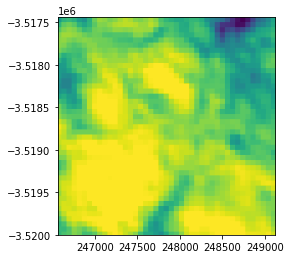

<AxesSubplot:>

In [11]:
from rasterio.plot import show,show_hist
show(dataset)

Do everything again for the label image.

In [14]:
dataset_gt = rasterio.open(df_sent2_14['filename_gt'][0])
gt = dataset_gt.read()

print('count: ', dataset_gt.count, 'width: ', dataset_gt.width, 'height: ', dataset_gt.height, 'name: ', \
      os.path.basename(dataset_gt.name), f'| bbox: {dataset_gt.bounds}')
print('Shape of the label image:', gt.shape)

count:  1 width:  256 height:  256 name:  labels.tif | bbox: BoundingBox(left=246560.0, bottom=-3520000.0, right=249120.0, top=-3517440.0)
Shape of the label image: (1, 256, 256)


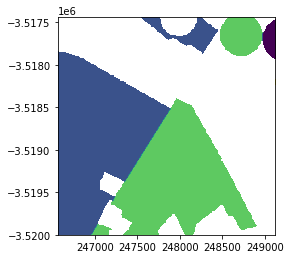

<AxesSubplot:>

In [15]:
from rasterio.plot import show,show_hist
show(dataset_gt)

Plotting a better version. Adding the labels and stuff.

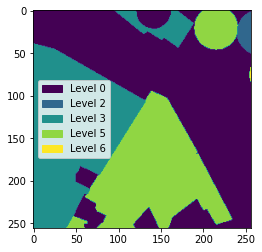

In [16]:
import matplotlib.patches as mpatches
values = np.unique(gt)
im = plt.imshow(gt[0,:,:])
colors = [ im.cmap(im.norm(value)) for value in values]

patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, loc=6)
plt.show()

PLotting an overlay of the actual loaded image (one band) and the according labels for this image.

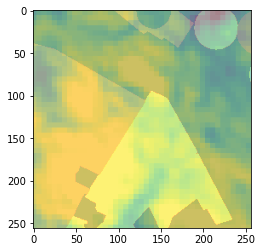

In [17]:
plt.imshow(band[0,:,:], alpha=0.6)
plt.imshow(gt[0,:,:], alpha=0.2, cmap='hot')
plt.show()

Stacking the data for all bands. <br>
I've chosen day 14 aka. 11 since this is the only day without clouds so far.

In [164]:
bands = list()
for num_band, filename_img in enumerate(df_sent2_14['filename_img']):
    dataset_curr = rasterio.open(filename_img)
    band = dataset.read()
    bands.append(band)

bands = np.squeeze(np.asarray(bands))
print('Shape of array with stacked bands:', bands.shape)


Shape of array with stacked bands: (13, 256, 256)


Plotting really rudimentary for an quick overview.

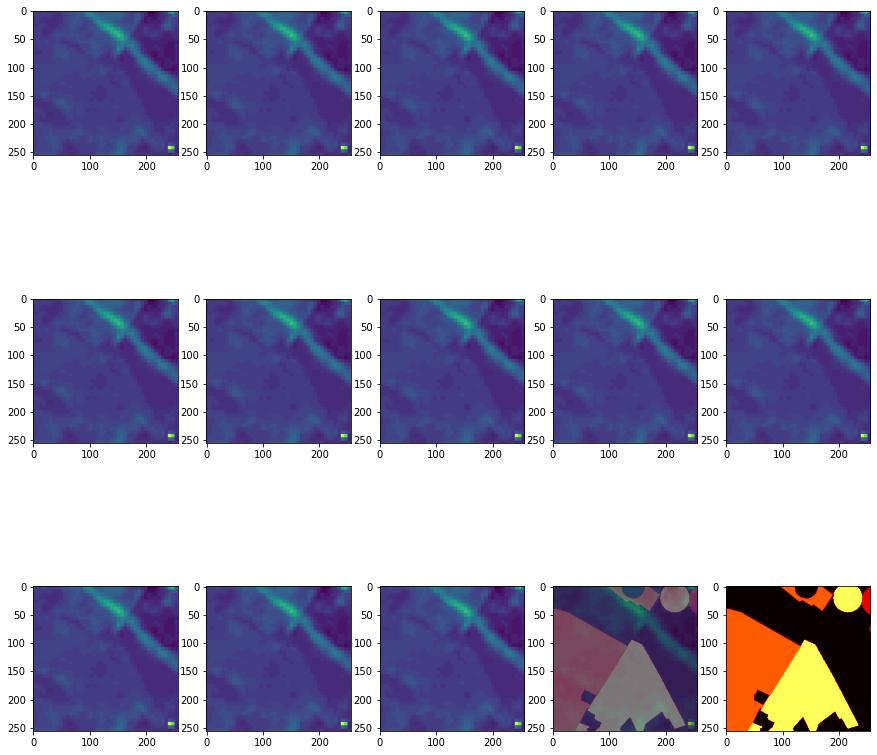

In [175]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15)) = plt.subplots(3,5,figsize=(15,15))
ax1.imshow(bands[0,:,:])
ax2.imshow(bands[1,:,:])
ax3.imshow(bands[2,:,:])
ax4.imshow(bands[3,:,:])
ax5.imshow(bands[4,:,:])
ax6.imshow(bands[5,:,:])
ax7.imshow(bands[6,:,:])
ax8.imshow(bands[7,:,:])
ax9.imshow(bands[8,:,:])
ax10.imshow(bands[9,:,:])
ax11.imshow(bands[10,:,:])
ax12.imshow(bands[11,:,:])
ax13.imshow(bands[12,:,:])
# second last is first band with label overlay
ax14.imshow(bands[0,:,:])
ax14.imshow(gt[0,:,:], alpha=0.3, cmap='hot')
# last ist pure label
ax15.imshow(gt[0,:,:], cmap='hot')
plt.show()